In [2]:
import pandas as pd
import seaborn as sns
%matplotlib inline

In [45]:
df = pd.read_csv("data/tinanic/train.csv")
"""
VARIABLE DESCRIPTIONS:
survival        Survival
                (0 = No; 1 = Yes)
pclass          Passenger Class
                (1 = 1st; 2 = 2nd; 3 = 3rd)
name            Name
sex             Sex
age             Age
sibsp           Number of Siblings/Spouses Aboard
parch           Number of Parents/Children Aboard
ticket          Ticket Number
fare            Passenger Fare
cabin           Cabin
embarked        Port of Embarkation
                (C = Cherbourg; Q = Queenstown; S = Southampton)

SPECIAL NOTES:
Pclass is a proxy for socio-economic status (SES)
 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower

Age is in Years; Fractional if Age less than One (1)
 If the Age is Estimated, it is in the form xx.5

With respect to the family relation variables (i.e. sibsp and parch)
some relations were ignored.  The following are the definitions used
for sibsp and parch.

Sibling:  Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic
Spouse:   Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiances Ignored)
Parent:   Mother or Father of Passenger Aboard Titanic
Child:    Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic

Other family relatives excluded from this study include cousins,
nephews/nieces, aunts/uncles, and in-laws.  Some children travelled
only with a nanny, therefore parch=0 for them.  As well, some
travelled with very close friends or neighbors in a village, however,
the definitions do not support such relations.

"""
df.sample(6)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
58,59,1,2,"West, Miss. Constance Mirium",female,5.00,1,2,C.A. 34651,27.7500,NaN,S
305,306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S
22,23,1,3,"McGowan, Miss. Anna ""Annie""",female,15.00,0,0,330923,8.0292,NaN,Q
883,884,0,2,"Banfield, Mr. Frederick James",male,28.00,0,0,C.A./SOTON 34068,10.5000,NaN,S
532,533,0,3,"Elias, Mr. Joseph Jr",male,17.00,1,1,2690,7.2292,NaN,C
419,420,0,3,"Van Impe, Miss. Catharina",female,10.00,0,2,345773,24.1500,NaN,S


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB


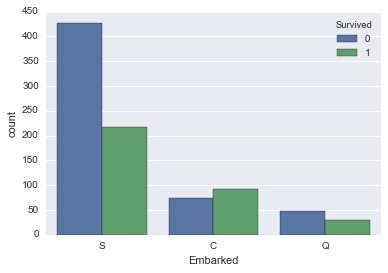

In [58]:
sns.countplot(data=df, hue="Survived", x="Embarked")

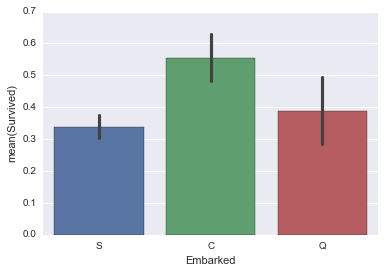

In [56]:
sns.barplot(data=df, x="Embarked", y="Survived")

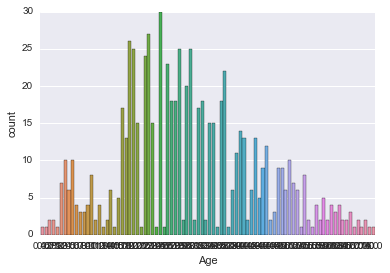

In [57]:
sns.countplot(data=df, x="Age")

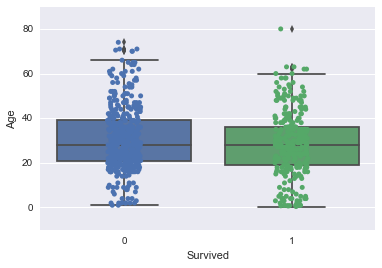

In [68]:
sns.boxplot(data=df, x="Survived", y="Age")
sns.stripplot(x="Survived", y="Age", data=df, jitter=True, edgecolor="gray")

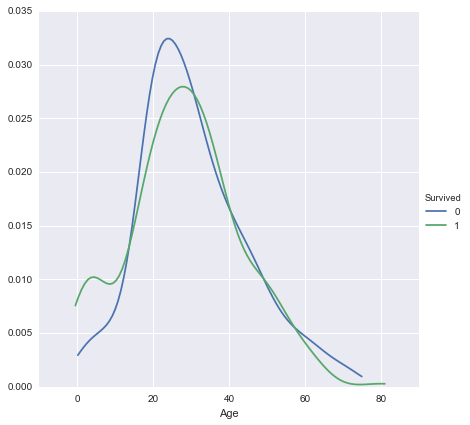

In [69]:
sns.FacetGrid(df, hue="Survived", size=6).map(sns.kdeplot, "Age").add_legend()

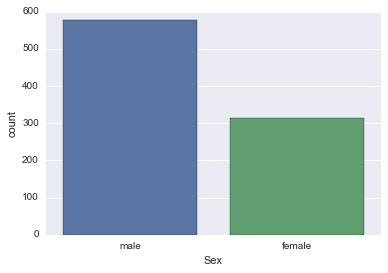

In [70]:
sns.countplot(data=df, x="Sex")

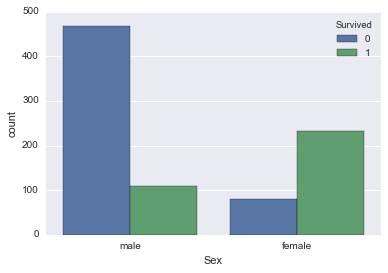

In [63]:
sns.countplot(data=df, hue="Survived", x="Sex")

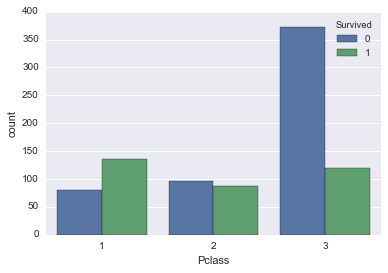

In [74]:
sns.countplot(data=df, hue="Survived", x="Pclass")

In [60]:
pd.get_dummies(df['Embarked'])

,C,Q,S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1
5,0,1,0
6,0,0,1
7,0,0,1
8,0,0,1
9,1,0,0
